In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
#import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'guncontrol_with_metadata_2017_04_05.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'guncontrol_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

#framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max() - pd.DateOffset(years=4)
print "Last date = ", last_date
last_year = last_date.year + 1

data = data[data['date'] <= last_date]
print data.shape


Loaded data for 16132 articles
Loaded tone annotations for 3707 articles
Last date =  2012-12-28 00:00:00
(11325, 28)


In [139]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)
print "Done"

Done


Grouped data into 84 periods


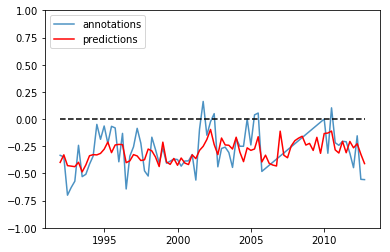

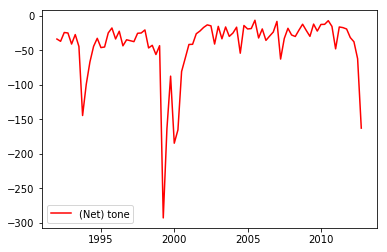

In [140]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True, group_directness=False)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone / grouped_tone_annotations.stories, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone / grouped.stories , 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
#ax.plot(grouped.f_date, grouped.Pro, c='purple', label='Pro')
#ax.plot(grouped.f_date, grouped.Anti, c='orange', label='Anti')
#ax.plot(grouped.f_date, grouped.Neutral, c='green', label='Neutral')
ax.legend(loc='upper left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.tone , 'r', label='(Net) tone')
ax.legend(loc='lower left')


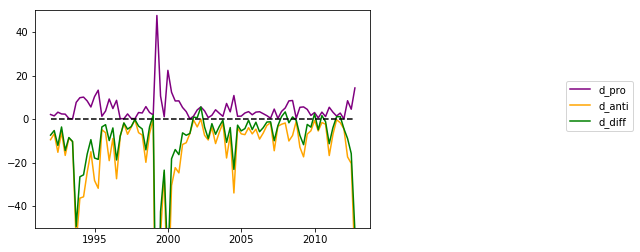

In [141]:
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']
    
grouped = misc.compute_dominance(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d_pro, c='purple', label='d_pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='orange', label='d_anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
ax.plot(grouped.f_date, grouped.d_diff, c='green', label='d_diff')
ax.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', label=None)

ax.set_ylim(-50, 50)
ax.legend(loc='upper right', bbox_to_anchor=(1.8, 0.7))


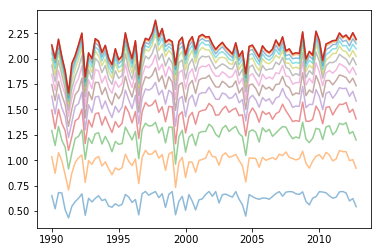

In [115]:
reload(misc)

fig, ax = plt.subplots()
grouped = misc.compute_truncated_entropy(grouped)
for j in range(2,15):
    ax.plot(grouped.f_date, grouped['entropy_' + str(j)], label='entropy_' + str(j), alpha=0.5)

ax.plot(grouped.f_date, grouped.entropy, label='entropy')

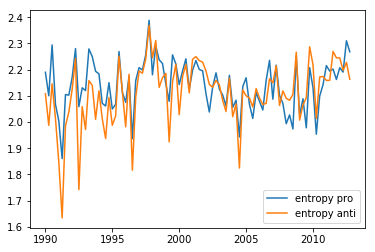

In [132]:
reload(misc)

grouped = misc.compute_signed_entropy(grouped)
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.entropy_pro, label='entropy pro')
ax.plot(grouped.f_date, grouped.entropy_anti, label='entropy anti')
grouped['toneXentropyPro'] = grouped['tone'] * grouped['entropy_pro']
grouped['toneXentropyAnti'] = grouped['tone'] * grouped['entropy_anti']
ax.legend()

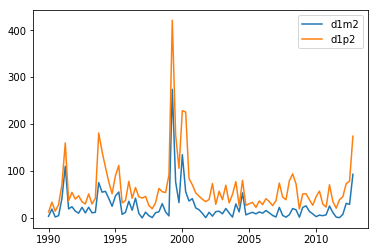

In [117]:
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d1m2, label='d1m2')
ax.plot(grouped.f_date, grouped.d1p2, label='d1p2')
ax.legend()
grouped['toneXd1m2'] = grouped['tone'] * grouped['d1m2']
grouped['toneXd1p2'] = grouped['tone'] * grouped['d1p2']



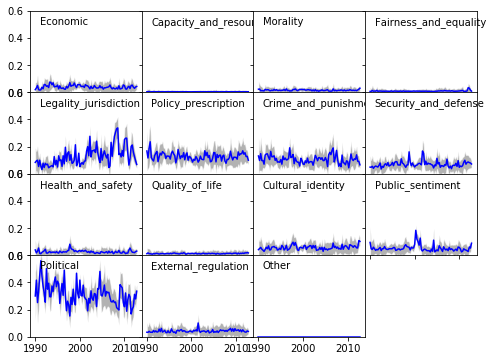

In [118]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.6)

set([4, 12, -1])
{12: '#d95f02', 4: '#1b9e77', -1: '#7570b3'}
set(['#1b9e77', '#d95f02'])


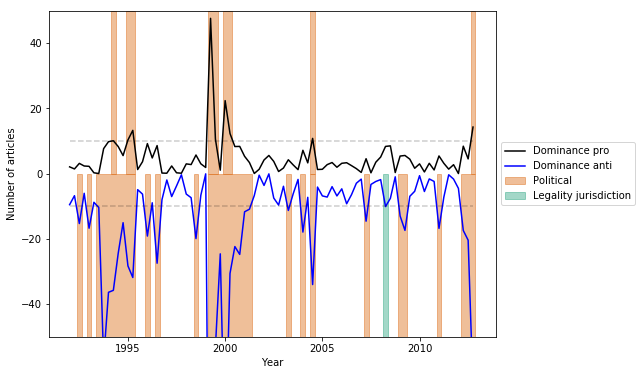

In [164]:
import re
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

CB6 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']

threshold = 10
grouped = misc.compute_dominance(grouped, threshold=threshold)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grouped.f_date, grouped.d_pro, c='black', label='Dominance pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='blue', label='Dominance anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
#grouped['d_diff2'] = grouped['d_pro2'] - grouped['d_anti2']
#ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')

pos_spans = []
anti_spans = []
pos_cur = -1
anti_cur = -1
top_set = set()
delta = grouped.iloc[1].f_date - grouped.iloc[0].f_date

for i, index in enumerate(grouped.index):
    row = grouped.loc[index]
    if row.top_pro != pos_cur:
        if i > 0 and pos_cur >= 0:
            pos_spans[-1] += [row.f_date - delta/2.0, pos_cur]
        if i < len(grouped.index) and row.top_pro >= 0:
            pos_spans.append([row.f_date - delta/2.0])
        pos_cur = row.top_pro
    if i == len(grouped.index) - 1 and pos_cur >= 0:
        pos_spans[-1] += [row.f_date + delta/2.0, pos_cur]
    top_set.add(int(row.top_pro))

    if row.top_anti != anti_cur:
        if i > 0 and anti_cur >= 0:
            anti_spans[-1] += [row.f_date - delta/2.0, anti_cur]
        if i < len(grouped.index) and row.top_anti >= 0:
            anti_spans.append([row.f_date - delta/2.0])
        anti_cur = row.top_anti
    if i == len(grouped.index) - 1 and anti_cur >= 0: 
        anti_spans[-1] += [row.f_date + delta/2.0, anti_cur]
    top_set.add(int(row.top_anti))

print top_set
    
# UNCOMMENT THIS LINE TO REFRESH COLOURS
colors = dict(zip(list(top_set), CB6))
print colors 

ylim = 50

colors_used = set()
for span in pos_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

for span in anti_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

print colors_used

ax.plot(grouped.f_date, np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.plot(grouped.f_date, -np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.set_ylim(-50, 50)
ax.set_ylabel('Number of articles')
ax.set_xlabel('Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/Users/dcard/Desktop/samesex_dominance_' + str(threshold) + '.pdf', bbox_inches='tight')

1990
Loaded 153 polls
           Varname     Date  Index     N       date  year  month  day  \
142     GUNLAWNORC  2/15/90  79.49   312 1990-02-15  1990      2   15   
143     GUNLAWNORC  4/15/90  80.38   586 1990-04-15  1990      4   15   
249       HHANDGUN  6/21/90  73.74  1254 1990-06-21  1990      6   21   
217       HALLGUNS  6/21/90  73.74  1254 1990-06-21  1990      6   21   
220  HANDGUNGALLUP  9/10/90  82.65  1031 1990-09-10  1990      9   10   

     quarter  p_month    ...     HANDGUNS  GUNABCAP  GUNSTRICTGALLUP  \
142        1        1    ...            0         0                0   
143        2        3    ...            0         0                0   
249        2        5    ...            0         0                0   
217        2        5    ...            0         0                0   
220        3        8    ...            0         0                0   

     BANGUNSPEW  BANGUNSGALLUP  HALLGUNS  GUNLAWY  HHANDGUN  FIREARMSNBC  \
142           0              0

(<matplotlib.figure.Figure at 0x117f8c0d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114003dd0>)

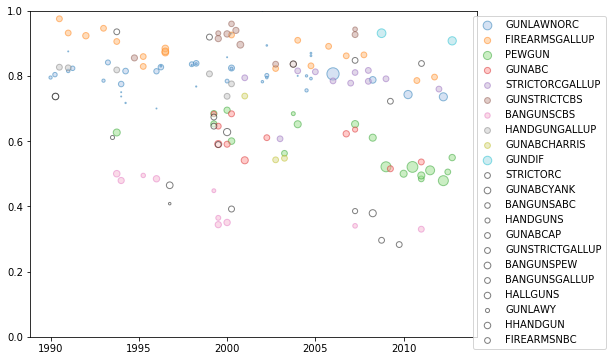

In [109]:
reload(misc)

filename = 'gun_control_for_wcalc_corrected.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
# drop one poll that seems redundant (with a seeming mistake)
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = int(q_i)
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 



reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=False)

(-1, 1)

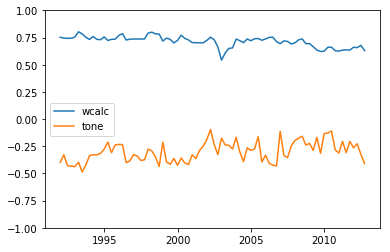

In [154]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    #mood = pd.read_csv('wcalc_gun_control_corrected_quarter_smoothed.csv', header=0)
    mood = pd.read_csv('wcalc_gun_control_corrected_subset_quarter_smoothed.csv', header=0)
    #mood = pd.read_csv('wcalc_immigration_quarter_unsmoothed.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# convert each quarter to a group (year/quarter)
if group_by == 'quarter':
    groups = mood.groupby('p_quarter')
elif group_by == 'month':
    groups = mood.groupby('p_month')
else:
    sys.exit()
    
# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()

# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed
grouped['mood_diff'] = grouped['mood'] - grouped['prev_mood']
grouped['transformed_diff'] = grouped['transformed'] - grouped['prev_transformed']

grouped['logTone'] = np.log(grouped['tone'] / np.mean(grouped['tone']))

#temp = pd.read_csv('immigration_grouped.csv')
#grouped['p_t'] = temp['p_t_means']

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.mood, label='wcalc')
ax.plot(grouped.f_date, grouped.tone / grouped.stories, label='tone')
#ax.plot(grouped.f_date, grouped.p_t, label='p_t')
ax.legend(loc='center left')
plt.ylim(-1, 1)



In [158]:
reload(stats)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['f_date'])
print np.mean(grouped.mood - fitted)
print np.std(grouped.mood - fitted)

Rmse: 0.037289761657
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     66.06
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           3.90e-12
Time:                        15:18:59   Log-Likelihood:                 158.10
No. Observations:                  84   AIC:                            -312.2
Df Residuals:                      82   BIC:                            -307.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.6369      1.34

In [162]:
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood'])


Rmse: 0.029521371056
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     153.4
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.21e-20
Time:                        15:37:33   Log-Likelihood:                 175.62
No. Observations:                  83   AIC:                            -347.2
Df Residuals:                      81   BIC:                            -342.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1272      0.04

In [161]:
reload(stats)
grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone'])
print model.conf_int()

Rmse: 0.0296382511157
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     76.29
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.89e-19
Time:                        15:37:27   Log-Likelihood:                 175.81
No. Observations:                  83   AIC:                            -345.6
Df Residuals:                      80   BIC:                            -338.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           

In [92]:
#grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'logTone'])


Rmse: 0.0285385714687
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     132.2
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.67e-28
Time:                        13:40:28   Log-Likelihood:                 213.14
No. Observations:                  99   AIC:                            -420.3
Df Residuals:                      96   BIC:                            -412.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0917      0.0

In [160]:
divisor = np.max([np.max(grouped['Pro'].values), np.max(grouped['Anti'].values)])
grouped['normalized_pro'] = grouped['Pro'] / divisor
grouped['normalized_anti'] = grouped['Anti'] / divisor
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_pro', 'normalized_anti'])


Rmse: 0.0296376296149
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     51.20
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.75e-18
Time:                        15:37:19   Log-Likelihood:                 176.33
No. Observations:                  83   AIC:                            -344.7
Df Residuals:                      79   BIC:                            -335.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           

In [157]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.0292195924891
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     53.43
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           5.74e-19
Time:                        15:13:23   Log-Likelihood:                 177.51
No. Observations:                  83   AIC:                            -347.0
Df Residuals:                      79   BIC:                            -337.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

In [124]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse, model = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.140005591982
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     66.15
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.25e-22
Time:                        13:50:46   Log-Likelihood:                 51.835
No. Observations:                  91   AIC:                            -95.67
Df Residuals:                      87   BIC:                            -85.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept        

In [41]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse = stats.ols(df=grouped, target='mood_diff', columns=['normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.0302449456014
                            OLS Regression Results                            
Dep. Variable:              mood_diff   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.116
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.127
Time:                        11:27:46   Log-Likelihood:                 174.13
No. Observations:                  83   AIC:                            -342.3
Df Residuals:                      80   BIC:                            -335.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

In [23]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy_pro', 'entropy_anti', 'toneXentropyPro', 'toneXentropyAnti'])



Rmse: 0.0337979935787
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     28.94
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           1.58e-18
Time:                        14:00:50   Log-Likelihood:                 182.77
No. Observations:                  91   AIC:                            -351.5
Df Residuals:                      84   BIC:                            -334.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         

In [21]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy'])


Rmse: 0.0301683500873
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     48.32
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           7.74e-18
Time:                        11:09:14   Log-Likelihood:                 174.86
No. Observations:                  83   AIC:                            -341.7
Df Residuals:                      79   BIC:                            -332.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1887      0.0

In [22]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy', 'toneXentropy'])


Rmse: 0.0303604749376
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     35.78
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           5.89e-17
Time:                        11:09:20   Log-Likelihood:                 174.86
No. Observations:                  83   AIC:                            -339.7
Df Residuals:                      78   BIC:                            -327.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.1848   

In [163]:
columns = ['prev_mood']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'Pro', 'Anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'd_pro', 'd_anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

Held-out RMSE: 0.0299313522973 ['prev_mood']
Held-out RMSE: 0.0303177388796 ['prev_mood', 'tone']
Held-out RMSE: 0.0306516346092 ['prev_mood', 'Pro', 'Anti']
Held-out RMSE: 0.029756985476 ['prev_mood', 'd_pro', 'd_anti']


In [96]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [97]:
tones = grouped.tone.values
n_periods = len(tones)
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, int(polls.question.values[i])] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
  GUNLAW	36
  PEWGUN	26
  GUNABC	20
FIREARMS	19
 BANGUNS	15
GUNSTRICT	13
STRICTORC	13
 HANDGUN	5
 GALGUN2	4
HANDGUNS	2
  GUNDIF	2
HALLGUNS	1
 GUNLAWY	1
  GUNPEW	1


''

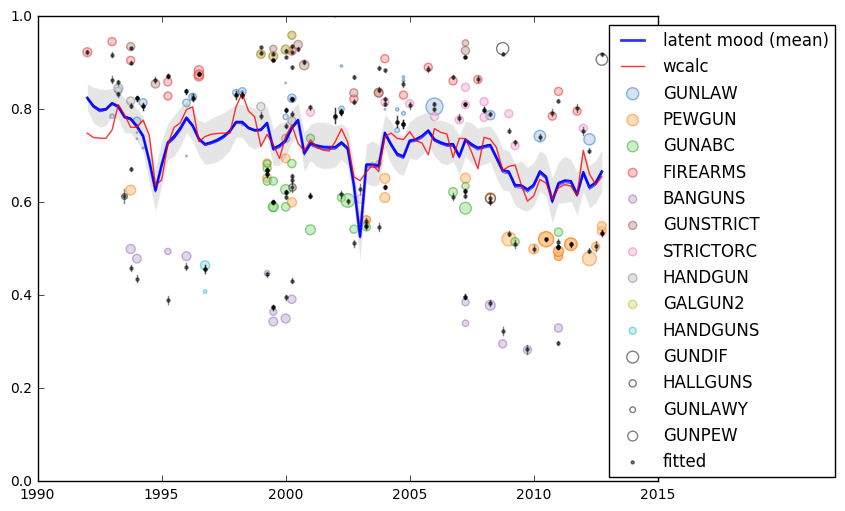

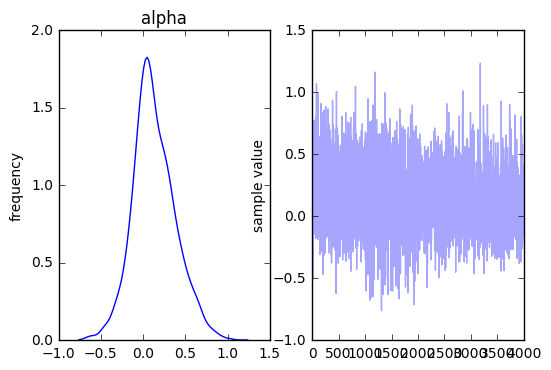

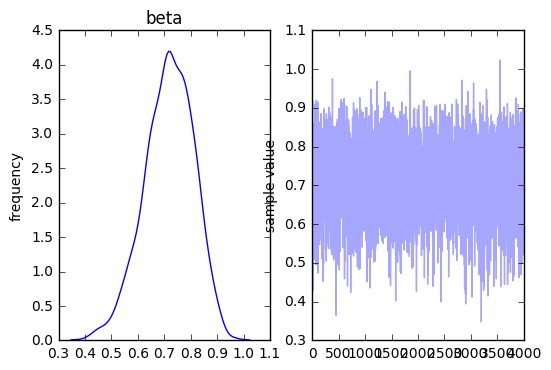

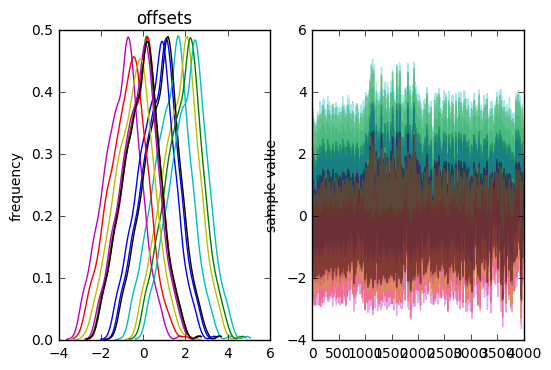

In [101]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

fit.plot('alpha')
fit.plot('beta')
#fit.plot('gamma')
fit.plot('offsets')

""

(0, 1)

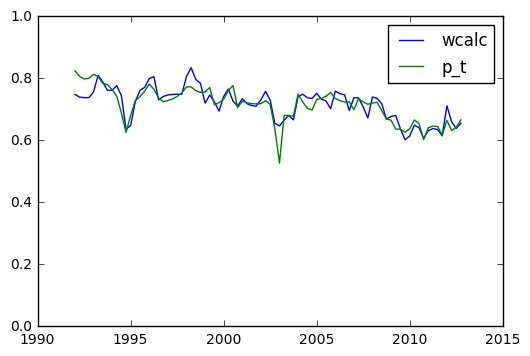

In [105]:
grouped['p_t'] = p_t_means
grouped.to_csv('guncontrol_grouped.csv')
grouped['prev_p_t'] = grouped['p_t'].shift().values

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.mood, label='wcalc')
ax.plot(grouped.f_date, grouped.p_t, label='p_t')
ax.legend()
plt.ylim(0, 1)

